<a href="https://colab.research.google.com/github/kanni5353/Trying-ML-/blob/main/HPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[link text](https://www.sysnet.ucsd.edu/projects/url/#datasets)
Dataset used for the below can be accessed through the provided link

In [5]:
!pip install scikit-learn numpy pandas matplotlib seaborn lightgbm xgboost imbalanced-learn tqdm

# Import all required libraries
import os
import gc
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import csr_matrix, hstack, vstack

# scikit-learn core modules
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.linear_model import (
    LogisticRegression, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier
)
from sklearn.svm import LinearSVC

# LightGBM for gradient boosting
import lightgbm as lgb

# Utility for exception handling
import traceback

In [6]:
# Upload your data file
print("Please upload your url_svmlight.tar.gz file")
uploaded = files.upload()

# Extract the uploaded file
!tar -xzf url_svmlight.tar.gz

# Verify the contents
!ls url_svmlight/

Please upload your url_svmlight.tar.gz file


Saving url_svmlight.tar.gz to url_svmlight.tar.gz
Day0.svm    Day119.svm	Day29.svm  Day48.svm  Day67.svm  Day86.svm
Day100.svm  Day11.svm	Day2.svm   Day49.svm  Day68.svm  Day87.svm
Day101.svm  Day120.svm	Day30.svm  Day4.svm   Day69.svm  Day88.svm
Day102.svm  Day12.svm	Day31.svm  Day50.svm  Day6.svm	 Day89.svm
Day103.svm  Day13.svm	Day32.svm  Day51.svm  Day70.svm  Day8.svm
Day104.svm  Day14.svm	Day33.svm  Day52.svm  Day71.svm  Day90.svm
Day105.svm  Day15.svm	Day34.svm  Day53.svm  Day72.svm  Day91.svm
Day106.svm  Day16.svm	Day35.svm  Day54.svm  Day73.svm  Day92.svm
Day107.svm  Day17.svm	Day36.svm  Day55.svm  Day74.svm  Day93.svm
Day108.svm  Day18.svm	Day37.svm  Day56.svm  Day75.svm  Day94.svm
Day109.svm  Day19.svm	Day38.svm  Day57.svm  Day76.svm  Day95.svm
Day10.svm   Day1.svm	Day39.svm  Day58.svm  Day77.svm  Day96.svm
Day110.svm  Day20.svm	Day3.svm   Day59.svm  Day78.svm  Day97.svm
Day111.svm  Day21.svm	Day40.svm  Day5.svm   Day79.svm  Day98.svm
Day112.svm  Day22.svm	Day41.svm  Day60.sv

In [7]:
class BatchURLClassifier:
    def __init__(self, data_dir="url_svmlight", batch_size=30, feature_selection='chi2', k_best=300):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.models = {}
        self.results = {}
        self.batch_results = []
        self.max_features = None
        self.feature_selection = feature_selection
        self.k_best = k_best
        print(f"Initializing URL Classifier with Feature Selection: {feature_selection.upper()} | Top K: {k_best}")

    def get_max_features(self):
        if self.max_features is None:
            max_dim = 0
            print("Scanning dataset for maximum feature dimension...")
            for day in tqdm(range(121)):
                try:
                    X, _ = self.load_day_data(day)
                    max_dim = max(max_dim, X.shape[1])
                    del X
                    _ = gc.collect()
                except Exception as e:
                    print(f"Warning: Could not load Day {day}: {str(e)}")
            self.max_features = max_dim
        return self.max_features

    def load_day_data(self, day_number):
        file_path = os.path.join(self.data_dir, f"Day{day_number}.svm")
        try:
            X, y = load_svmlight_file(file_path)
            return X, y
        except Exception as e:
            raise RuntimeError(f"Error loading {file_path}: {str(e)}")

    def pad_features(self, X, max_features):
        if X.shape[1] < max_features:
            padding = csr_matrix((X.shape[0], max_features - X.shape[1]))
            X = hstack([X, padding])
        elif X.shape[1] > max_features:
            X = X[:, :max_features]
        return X

    def apply_feature_selection(self, X_train, y_train, X_test):
        if self.feature_selection == 'chi2':
            X_train = X_train.tocsc()
            X_test = X_test.tocsc()
            selector = SelectKBest(score_func=chi2, k=self.k_best)
            X_train = selector.fit_transform(X_train, y_train)
            X_test = selector.transform(X_test)
        elif self.feature_selection == 'l1':
            selector = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000), max_features=self.k_best)
            X_train = selector.fit_transform(X_train, y_train)
            X_test = selector.transform(X_test)
        elif self.feature_selection == 'l2':
            selector = SelectFromModel(LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000), max_features=self.k_best)
            X_train = selector.fit_transform(X_train, y_train)
            X_test = selector.transform(X_test)
        return X_train, X_test

    def load_batch_data(self, start_day, end_day):
        X_list = []
        y_list = []
        max_features = self.get_max_features()

        for day in tqdm(range(start_day, end_day + 1), desc=f"Loading days {start_day}-{end_day}"):
            try:
                X_day, y_day = self.load_day_data(day)
                X_day = self.pad_features(X_day, max_features)
                y_day = (y_day + 1) / 2
                X_list.append(X_day)
                y_list.append(y_day)
            except Exception as e:
                print(f"Warning: Could not load Day {day}: {str(e)}")

        if not X_list:
            raise ValueError("No data could be loaded for this batch")

        X = vstack(X_list)
        y = np.concatenate(y_list)
        return X, y

    def train_evaluate_models(self, X_train, X_test, y_train, y_test):
        models = {
            'Logistic Regression': LogisticRegression(max_iter=1000),
            'Linear SVM': LinearSVC(max_iter=1000),
            'LightGBM': lgb.LGBMClassifier(n_estimators=100, force_row_wise=True),
            'SGD (Logistic)': SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3),
            'Ridge Classifier': RidgeClassifier(),
            'Passive Aggressive': PassiveAggressiveClassifier(max_iter=1000, tol=1e-3),
        }

        results = {}
        for name, model in models.items():
            try:
                model.fit(X_train, y_train)
                y_test_pred = model.predict(X_test)
                y_train_pred = model.predict(X_train)

                train_f1 = f1_score(y_train, y_train_pred)
                test_f1 = f1_score(y_test, y_test_pred)

                print(f"\nTraining {name}...")
                print(f"{name} Results:")
                print(f"- accuracy: {accuracy_score(y_test, y_test_pred):.3f}")
                print(f"- precision: {precision_score(y_test, y_test_pred):.3f}")
                print(f"- recall: {recall_score(y_test, y_test_pred):.3f}")
                print(f"- f1: {test_f1:.3f}")
                print(f"- roc_auc: {roc_auc_score(y_test, y_test_pred):.3f}")
                print(f"\n🧪 Overfitting Test: Train F1 - Test F1 = {train_f1:.4f} - {test_f1:.4f} = {train_f1 - test_f1:.4f}")

                results[name] = {
                    'test_accuracy': accuracy_score(y_test, y_test_pred),
                    'test_precision': precision_score(y_test, y_test_pred),
                    'test_recall': recall_score(y_test, y_test_pred),
                    'test_f1': test_f1,
                    'overfit_gap': train_f1 - test_f1,
                    'roc_auc': roc_auc_score(y_test, y_test_pred),
                    'confusion_matrix': confusion_matrix(y_test, y_test_pred)
                }
            except Exception as e:
                results[name] = {'error': str(e)}
        return results

    def process_batch(self, start_day, end_day):
        try:
            X, y = self.load_batch_data(start_day, end_day)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
            X_train, X_test = self.apply_feature_selection(X_train, y_train, X_test)
            results = self.train_evaluate_models(X_train, X_test, y_train, y_test)
            return results
        except Exception as e:
            print(f"Error in batch {start_day}-{end_day}: {e}")
            traceback.print_exc()
            return None

    def process_all_batches(self):
        for batch_start in range(0, 121, self.batch_size):
            batch_end = min(batch_start + self.batch_size - 1, 120)
            result = self.process_batch(batch_start, batch_end)
            if result:
                self.batch_results.append({
                    'batch_start': batch_start,
                    'batch_end': batch_end,
                    'results': result
                })
                print(f"\n✅ Finished Batch: Days {batch_start}-{batch_end}")
                best_model = max(result.items(), key=lambda x: x[1]['test_f1'] if 'test_f1' in x[1] else 0)
                if 'confusion_matrix' in best_model[1]:
                    print(f"\n📊 Confusion Matrix for Best Model ({best_model[0]})")
                    disp = ConfusionMatrixDisplay(confusion_matrix=best_model[1]['confusion_matrix'])
                    disp.plot()
                    plt.show()
        return self.batch_results

    def plot_batch_results(self):
        if not self.batch_results:
            print("No results to plot")
            return

        metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'overfit_gap', 'roc_auc']
        models = list(self.batch_results[0]['results'].keys())

        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        axes = axes.ravel()

        for i, metric in enumerate(metrics):
            ax = axes[i]
            for model in models:
                values = [batch['results'][model][metric] for batch in self.batch_results if 'error' not in batch['results'][model]]
                ax.plot(range(1, len(values)+1), values, label=model, marker='o')
            ax.set_title(f'{metric.upper()} across batches')
            ax.set_xlabel('Batch Number')
            ax.set_ylabel(metric)
            ax.legend()

        plt.tight_layout()
        plt.show()


Initializing URL Classifier with Feature Selection: L1 | Top K: 300
Starting URL Classification
User: kanni5353
--------------------------------------------------
Scanning dataset for maximum feature dimension...


Loading days 0-29: 100%|██████████| 30/30 [00:49<00:00,  1.66s/it]



Training Logistic Regression...
Logistic Regression Results:
- accuracy: 0.971
- precision: 0.958
- recall: 0.963
- f1: 0.961
- roc_auc: 0.970

🧪 Overfitting Test: Train F1 - Test F1 = 0.9612 - 0.9608 = 0.0004

Training Linear SVM...
Linear SVM Results:
- accuracy: 0.972
- precision: 0.957
- recall: 0.967
- f1: 0.962
- roc_auc: 0.971

🧪 Overfitting Test: Train F1 - Test F1 = 0.9631 - 0.9623 = 0.0009


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 173972, number of negative: 302828
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 476800, number of used features: 175
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.364874 -> initscore=-0.554271
[LightGBM] [Info] Start training from score -0.554271


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Training LightGBM...
LightGBM Results:
- accuracy: 0.984
- precision: 0.973
- recall: 0.982
- f1: 0.978
- roc_auc: 0.983

🧪 Overfitting Test: Train F1 - Test F1 = 0.9784 - 0.9777 = 0.0007

Training SGD (Logistic)...
SGD (Logistic) Results:
- accuracy: 0.972
- precision: 0.945
- recall: 0.979
- f1: 0.962
- roc_auc: 0.973

🧪 Overfitting Test: Train F1 - Test F1 = 0.9625 - 0.9617 = 0.0009

Training Ridge Classifier...
Ridge Classifier Results:
- accuracy: 0.966
- precision: 0.925
- recall: 0.987
- f1: 0.955
- roc_auc: 0.971

🧪 Overfitting Test: Train F1 - Test F1 = 0.9562 - 0.9553 = 0.0009

Training Passive Aggressive...
Passive Aggressive Results:
- accuracy: 0.966
- precision: 0.977
- recall: 0.928
- f1: 0.952
- roc_auc: 0.957

🧪 Overfitting Test: Train F1 - Test F1 = 0.9520 - 0.9516 = 0.0004

✅ Finished Batch: Days 0-29

📊 Confusion Matrix for Best Model (LightGBM)


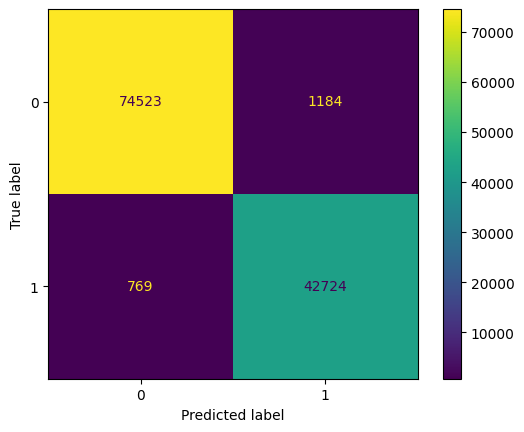

Loading days 30-59: 100%|██████████| 30/30 [00:57<00:00,  1.90s/it]



Training Logistic Regression...
Logistic Regression Results:
- accuracy: 0.968
- precision: 0.951
- recall: 0.946
- f1: 0.948
- roc_auc: 0.962

🧪 Overfitting Test: Train F1 - Test F1 = 0.9507 - 0.9483 = 0.0023

Training Linear SVM...
Linear SVM Results:
- accuracy: 0.969
- precision: 0.952
- recall: 0.949
- f1: 0.950
- roc_auc: 0.964

🧪 Overfitting Test: Train F1 - Test F1 = 0.9525 - 0.9502 = 0.0023


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 143634, number of negative: 320470
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 464104, number of used features: 197
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.309487 -> initscore=-0.802520
[LightGBM] [Info] Start training from score -0.802520


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Training LightGBM...
LightGBM Results:
- accuracy: 0.979
- precision: 0.967
- recall: 0.964
- f1: 0.966
- roc_auc: 0.975

🧪 Overfitting Test: Train F1 - Test F1 = 0.9660 - 0.9656 = 0.0005

Training SGD (Logistic)...
SGD (Logistic) Results:
- accuracy: 0.966
- precision: 0.932
- recall: 0.960
- f1: 0.946
- roc_auc: 0.964

🧪 Overfitting Test: Train F1 - Test F1 = 0.9460 - 0.9457 = 0.0002

Training Ridge Classifier...
Ridge Classifier Results:
- accuracy: 0.963
- precision: 0.914
- recall: 0.971
- f1: 0.942
- roc_auc: 0.965

🧪 Overfitting Test: Train F1 - Test F1 = 0.9417 - 0.9417 = 0.0000

Training Passive Aggressive...
Passive Aggressive Results:
- accuracy: 0.970
- precision: 0.966
- recall: 0.937
- f1: 0.951
- roc_auc: 0.961

🧪 Overfitting Test: Train F1 - Test F1 = 0.9537 - 0.9514 = 0.0023

✅ Finished Batch: Days 30-59

📊 Confusion Matrix for Best Model (LightGBM)


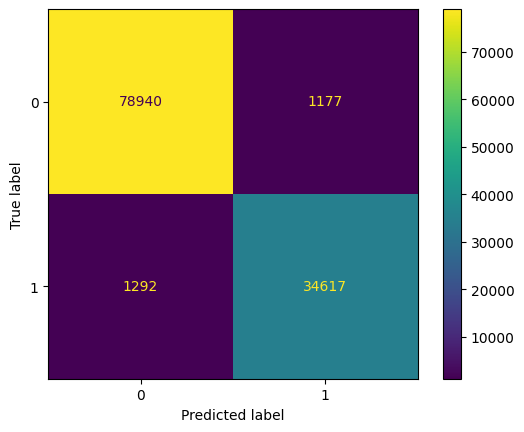

Loading days 60-89: 100%|██████████| 30/30 [00:50<00:00,  1.70s/it]



Training Logistic Regression...
Logistic Regression Results:
- accuracy: 0.974
- precision: 0.954
- recall: 0.962
- f1: 0.958
- roc_auc: 0.971

🧪 Overfitting Test: Train F1 - Test F1 = 0.9588 - 0.9579 = 0.0009

Training Linear SVM...
Linear SVM Results:
- accuracy: 0.975
- precision: 0.953
- recall: 0.965
- f1: 0.959
- roc_auc: 0.972

🧪 Overfitting Test: Train F1 - Test F1 = 0.9601 - 0.9591 = 0.0011


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 146786, number of negative: 333214
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.305804 -> initscore=-0.819809
[LightGBM] [Info] Start training from score -0.819809


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Training LightGBM...
LightGBM Results:
- accuracy: 0.987
- precision: 0.980
- recall: 0.978
- f1: 0.979
- roc_auc: 0.984

🧪 Overfitting Test: Train F1 - Test F1 = 0.9790 - 0.9787 = 0.0003

Training SGD (Logistic)...
SGD (Logistic) Results:
- accuracy: 0.965
- precision: 0.937
- recall: 0.951
- f1: 0.944
- roc_auc: 0.961

🧪 Overfitting Test: Train F1 - Test F1 = 0.9442 - 0.9440 = 0.0002

Training Ridge Classifier...
Ridge Classifier Results:
- accuracy: 0.965
- precision: 0.909
- recall: 0.984
- f1: 0.945
- roc_auc: 0.970

🧪 Overfitting Test: Train F1 - Test F1 = 0.9452 - 0.9453 = -0.0001

Training Passive Aggressive...
Passive Aggressive Results:
- accuracy: 0.975
- precision: 0.953
- recall: 0.964
- f1: 0.959
- roc_auc: 0.972

🧪 Overfitting Test: Train F1 - Test F1 = 0.9600 - 0.9587 = 0.0013

✅ Finished Batch: Days 60-89

📊 Confusion Matrix for Best Model (LightGBM)


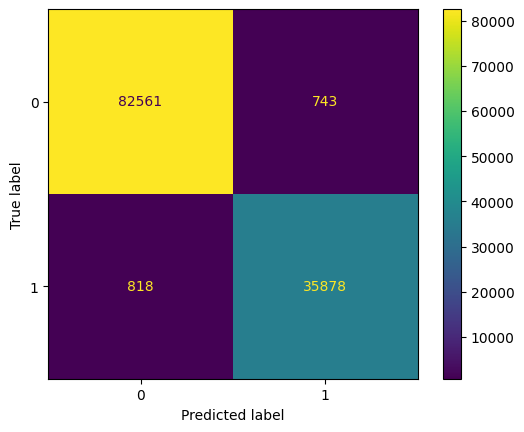

Loading days 90-119: 100%|██████████| 30/30 [00:54<00:00,  1.82s/it]



Training Logistic Regression...
Logistic Regression Results:
- accuracy: 0.974
- precision: 0.954
- recall: 0.971
- f1: 0.963
- roc_auc: 0.973

🧪 Overfitting Test: Train F1 - Test F1 = 0.9632 - 0.9625 = 0.0007

Training Linear SVM...
Linear SVM Results:
- accuracy: 0.977
- precision: 0.953
- recall: 0.979
- f1: 0.966
- roc_auc: 0.977

🧪 Overfitting Test: Train F1 - Test F1 = 0.9673 - 0.9662 = 0.0011


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 163689, number of negative: 316311
[LightGBM] [Info] Total Bins 958
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.341019 -> initscore=-0.658758
[LightGBM] [Info] Start training from score -0.658758


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Training LightGBM...
LightGBM Results:
- accuracy: 0.989
- precision: 0.983
- recall: 0.985
- f1: 0.984
- roc_auc: 0.988

🧪 Overfitting Test: Train F1 - Test F1 = 0.9842 - 0.9838 = 0.0004

Training SGD (Logistic)...
SGD (Logistic) Results:
- accuracy: 0.971
- precision: 0.939
- recall: 0.980
- f1: 0.959
- roc_auc: 0.973

🧪 Overfitting Test: Train F1 - Test F1 = 0.9587 - 0.9588 = -0.0002

Training Ridge Classifier...
Ridge Classifier Results:
- accuracy: 0.961
- precision: 0.907
- recall: 0.987
- f1: 0.945
- roc_auc: 0.967

🧪 Overfitting Test: Train F1 - Test F1 = 0.9447 - 0.9452 = -0.0005

Training Passive Aggressive...
Passive Aggressive Results:
- accuracy: 0.972
- precision: 0.928
- recall: 0.994
- f1: 0.960
- roc_auc: 0.977

🧪 Overfitting Test: Train F1 - Test F1 = 0.9606 - 0.9597 = 0.0009

✅ Finished Batch: Days 90-119

📊 Confusion Matrix for Best Model (LightGBM)


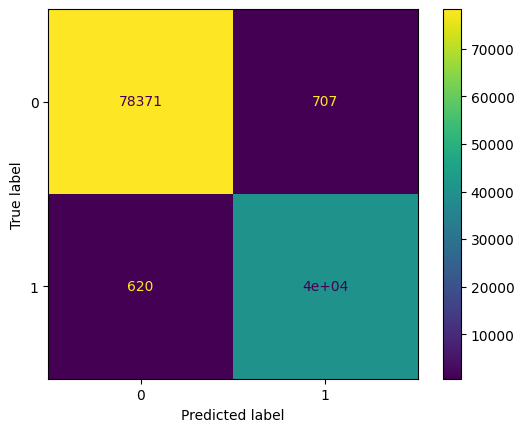

Loading days 120-120: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]



Training Logistic Regression...
Logistic Regression Results:
- accuracy: 0.985
- precision: 0.977
- recall: 0.979
- f1: 0.978
- roc_auc: 0.983

🧪 Overfitting Test: Train F1 - Test F1 = 0.9879 - 0.9780 = 0.0098

Training Linear SVM...
Linear SVM Results:
- accuracy: 0.989
- precision: 0.984
- recall: 0.985
- f1: 0.984
- roc_auc: 0.988

🧪 Overfitting Test: Train F1 - Test F1 = 0.9943 - 0.9844 = 0.0099


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 5635, number of negative: 10365
[LightGBM] [Info] Total Bins 1187
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 247
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.352187 -> initscore=-0.609438
[LightGBM] [Info] Start training from score -0.609438


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Training LightGBM...
LightGBM Results:
- accuracy: 0.991
- precision: 0.985
- recall: 0.989
- f1: 0.987
- roc_auc: 0.990

🧪 Overfitting Test: Train F1 - Test F1 = 0.9991 - 0.9869 = 0.0122

Training SGD (Logistic)...
SGD (Logistic) Results:
- accuracy: 0.984
- precision: 0.975
- recall: 0.979
- f1: 0.977
- roc_auc: 0.983

🧪 Overfitting Test: Train F1 - Test F1 = 0.9862 - 0.9770 = 0.0092

Training Ridge Classifier...
Ridge Classifier Results:
- accuracy: 0.982
- precision: 0.968
- recall: 0.981
- f1: 0.974
- roc_auc: 0.982

🧪 Overfitting Test: Train F1 - Test F1 = 0.9813 - 0.9743 = 0.0071

Training Passive Aggressive...
Passive Aggressive Results:
- accuracy: 0.982
- precision: 0.956
- recall: 0.994
- f1: 0.975
- roc_auc: 0.985

🧪 Overfitting Test: Train F1 - Test F1 = 0.9812 - 0.9749 = 0.0062

✅ Finished Batch: Days 120-120

📊 Confusion Matrix for Best Model (LightGBM)


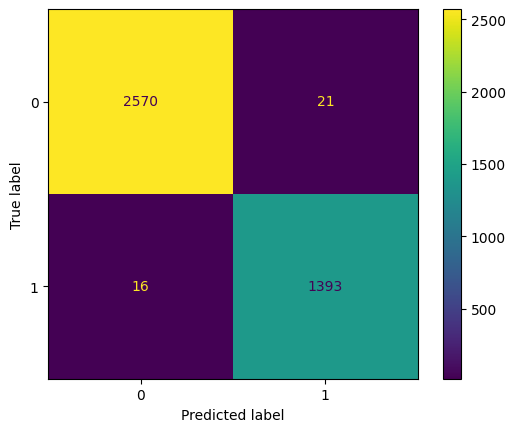


All batches processed successfully!


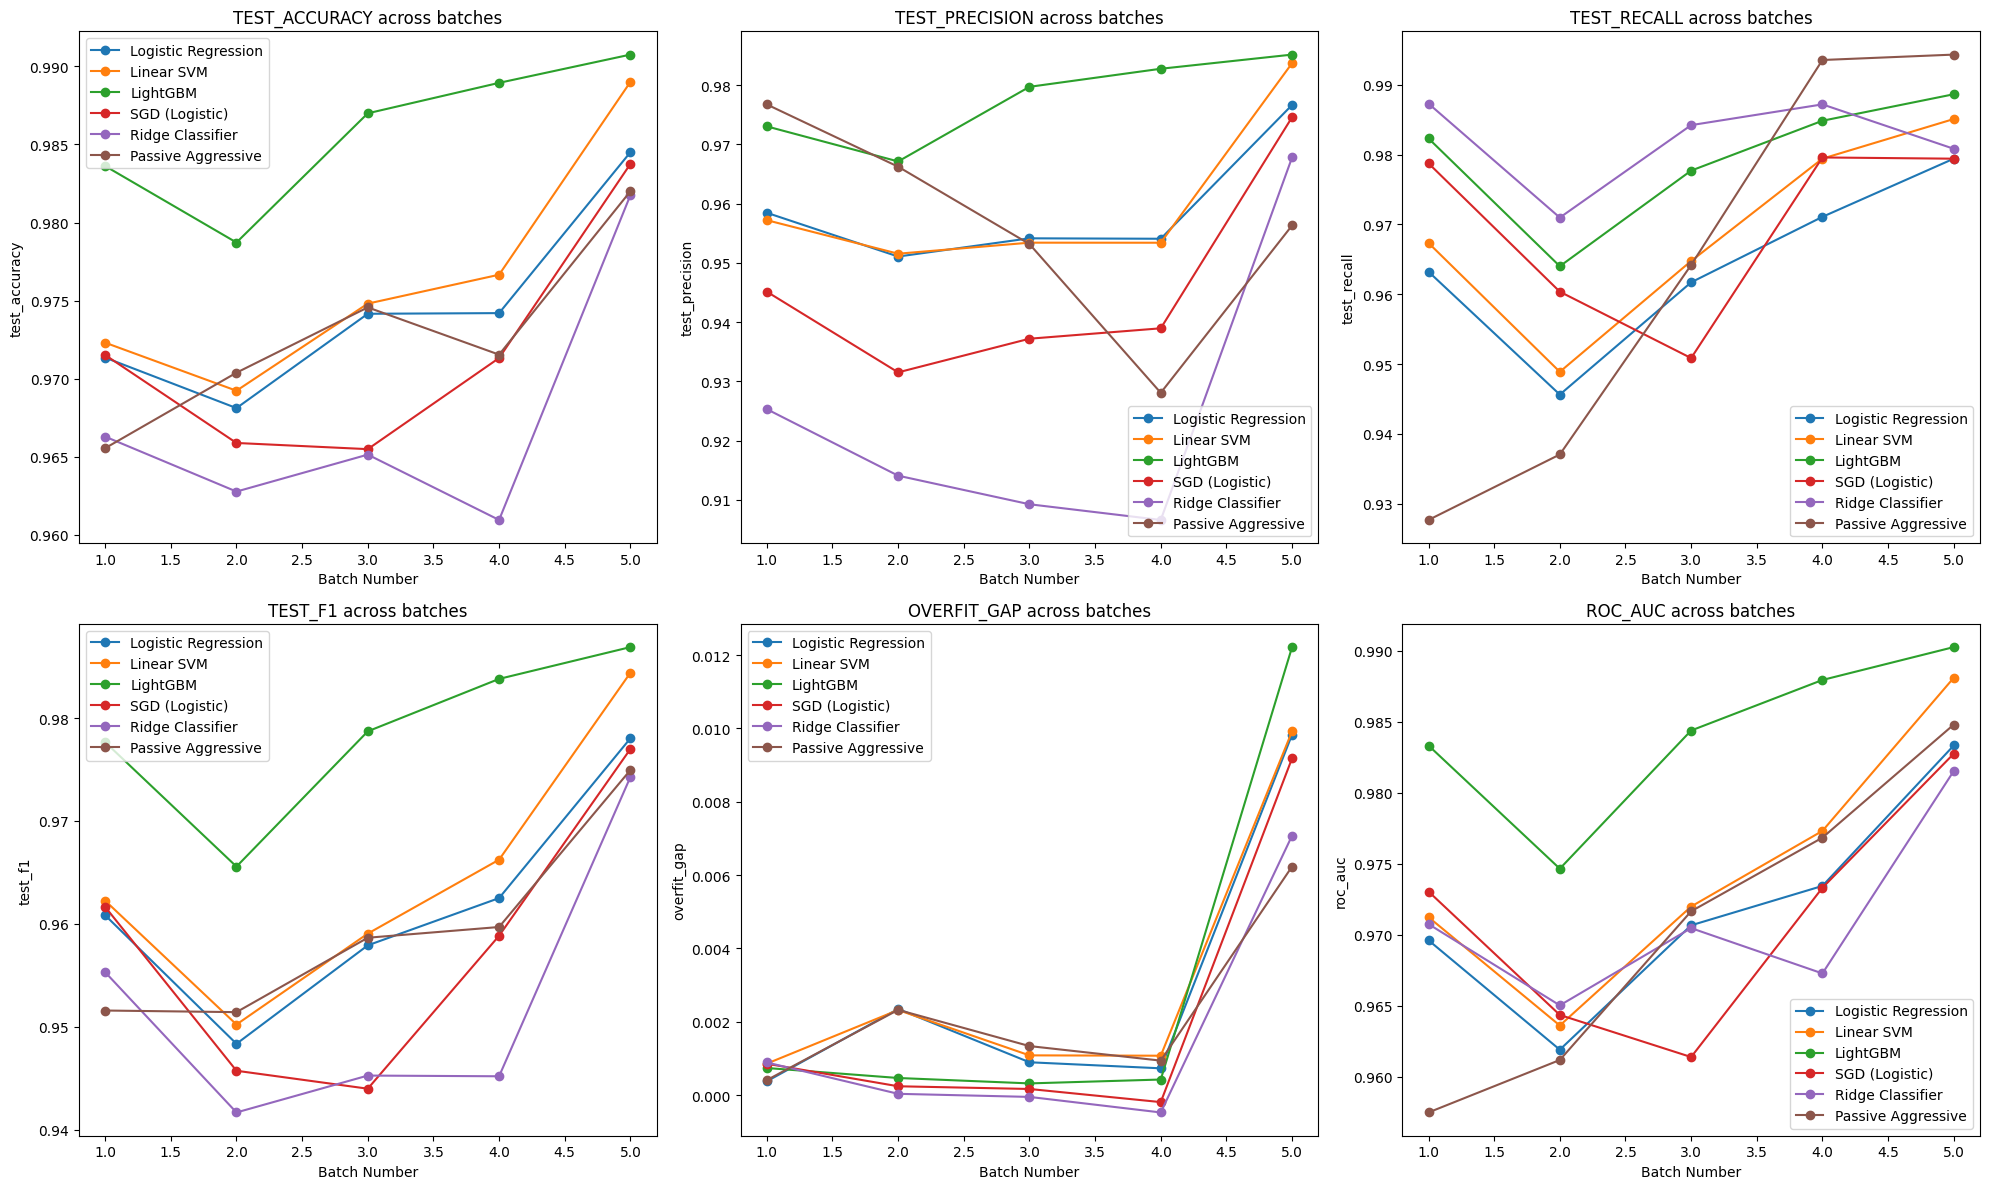

In [8]:
def run_classification():
    try:
        classifier = BatchURLClassifier(
            data_dir="url_svmlight",
            batch_size=30,
            feature_selection='l1',  # Options: 'chi2', 'l1', 'l2'
            k_best=300
        )

        print(f"Starting URL Classification")
        print(f"User: kanni5353")
        print("-" * 50)

        results = classifier.process_all_batches()

        if results and len(results) > 0:
            print("\nAll batches processed successfully!")
            classifier.plot_batch_results()
        else:
            print("\u26a0\ufe0f No results were generated. Please check the error messages above.")

    except Exception as e:
        print(f"An error occurred during classification: {str(e)}")
        traceback.print_exc()

run_classification()

Initializing URL Classifier with Feature Selection: L1 | Top K: 300
Starting URL Classification
User: kanni5353
--------------------------------------------------
Scanning dataset for maximum feature dimension...


Loading days 0-60: 100%|██████████| 61/61 [01:46<00:00,  1.75s/it]



Training Logistic Regression...
Logistic Regression Results:
- accuracy: 0.965
- precision: 0.939
- recall: 0.957
- f1: 0.948
- roc_auc: 0.963

🧪 Overfitting Test: Train F1 - Test F1 = 0.9489 - 0.9482 = 0.0006

Training Linear SVM...
Linear SVM Results:
- accuracy: 0.965
- precision: 0.940
- recall: 0.959
- f1: 0.949
- roc_auc: 0.964

🧪 Overfitting Test: Train F1 - Test F1 = 0.9499 - 0.9491 = 0.0008


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 322954, number of negative: 633950
[LightGBM] [Info] Total Bins 688
[LightGBM] [Info] Number of data points in the train set: 956904, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.337499 -> initscore=-0.674460
[LightGBM] [Info] Start training from score -0.674460


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Training LightGBM...
LightGBM Results:
- accuracy: 0.974
- precision: 0.976
- recall: 0.948
- f1: 0.962
- roc_auc: 0.968

🧪 Overfitting Test: Train F1 - Test F1 = 0.9624 - 0.9616 = 0.0008

Training SGD (Logistic)...
SGD (Logistic) Results:
- accuracy: 0.961
- precision: 0.916
- recall: 0.973
- f1: 0.944
- roc_auc: 0.964

🧪 Overfitting Test: Train F1 - Test F1 = 0.9431 - 0.9436 = -0.0005

Training Ridge Classifier...
Ridge Classifier Results:
- accuracy: 0.956
- precision: 0.899
- recall: 0.979
- f1: 0.937
- roc_auc: 0.962

🧪 Overfitting Test: Train F1 - Test F1 = 0.9377 - 0.9373 = 0.0004

Training Passive Aggressive...
Passive Aggressive Results:
- accuracy: 0.964
- precision: 0.956
- recall: 0.938
- f1: 0.947
- roc_auc: 0.958

🧪 Overfitting Test: Train F1 - Test F1 = 0.9481 - 0.9466 = 0.0015

✅ Finished Batch: Days 0-60

📊 Confusion Matrix for Best Model (LightGBM)


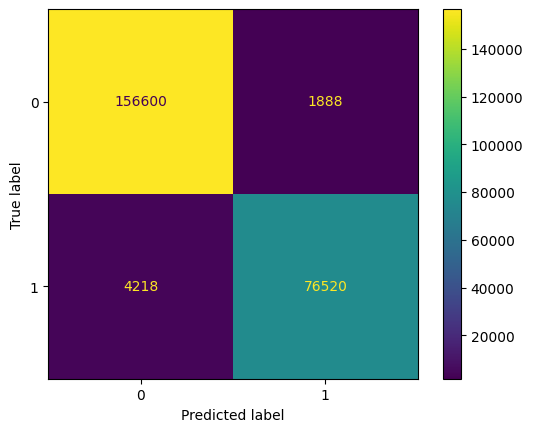

Loading days 61-120: 100%|██████████| 60/60 [01:38<00:00,  1.64s/it]



Training Logistic Regression...
Logistic Regression Results:
- accuracy: 0.965
- precision: 0.938
- recall: 0.955
- f1: 0.946
- roc_auc: 0.962

🧪 Overfitting Test: Train F1 - Test F1 = 0.9457 - 0.9462 = -0.0005

Training Linear SVM...
Linear SVM Results:
- accuracy: 0.966
- precision: 0.938
- recall: 0.957
- f1: 0.948
- roc_auc: 0.964

🧪 Overfitting Test: Train F1 - Test F1 = 0.9478 - 0.9476 = 0.0001


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 310762, number of negative: 649238
[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 212
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.323710 -> initscore=-0.736772
[LightGBM] [Info] Start training from score -0.736772


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Training LightGBM...
LightGBM Results:
- accuracy: 0.980
- precision: 0.969
- recall: 0.971
- f1: 0.970
- roc_auc: 0.978

🧪 Overfitting Test: Train F1 - Test F1 = 0.9708 - 0.9697 = 0.0012

Training SGD (Logistic)...
SGD (Logistic) Results:
- accuracy: 0.964
- precision: 0.917
- recall: 0.976
- f1: 0.946
- roc_auc: 0.967

🧪 Overfitting Test: Train F1 - Test F1 = 0.9459 - 0.9455 = 0.0004

Training Ridge Classifier...
Ridge Classifier Results:
- accuracy: 0.957
- precision: 0.893
- recall: 0.983
- f1: 0.936
- roc_auc: 0.964

🧪 Overfitting Test: Train F1 - Test F1 = 0.9374 - 0.9362 = 0.0012

Training Passive Aggressive...
Passive Aggressive Results:
- accuracy: 0.960
- precision: 0.957
- recall: 0.918
- f1: 0.937
- roc_auc: 0.949

🧪 Overfitting Test: Train F1 - Test F1 = 0.9366 - 0.9368 = -0.0003

✅ Finished Batch: Days 61-120

📊 Confusion Matrix for Best Model (LightGBM)


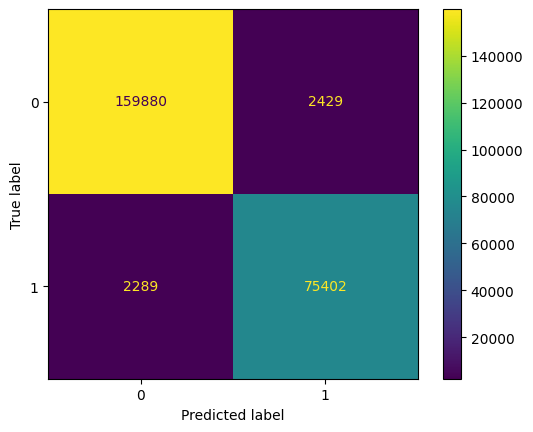


All batches processed successfully!


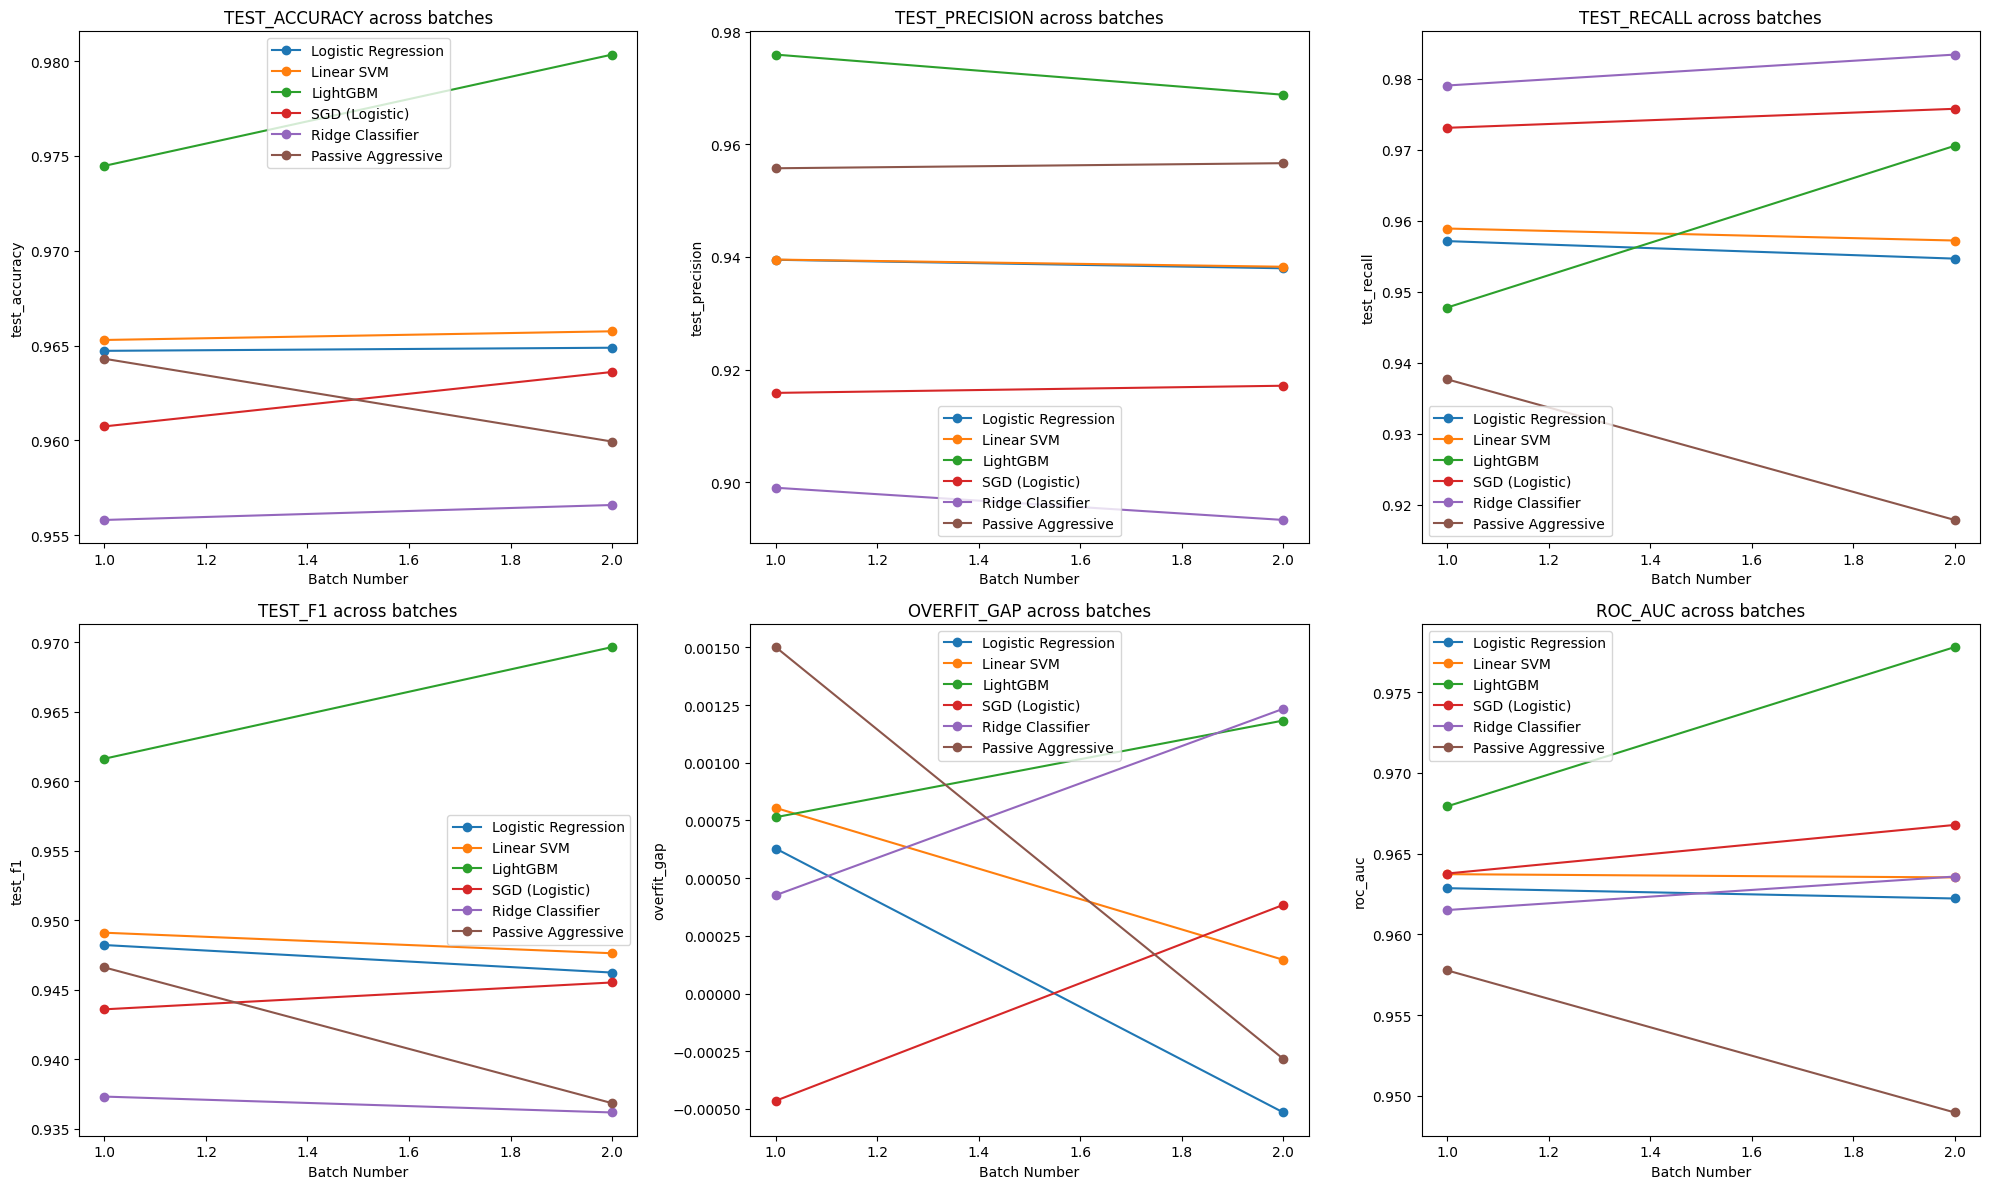

In [9]:
def run_classification():
    try:
        classifier = BatchURLClassifier(
            data_dir="url_svmlight",
            batch_size=61,
            feature_selection='l1',  # Options: 'chi2', 'l1', 'l2'
            k_best=300
        )

        print(f"Starting URL Classification")
        print(f"User: kanni5353")
        print("-" * 50)

        results = classifier.process_all_batches()

        if results and len(results) > 0:
            print("\nAll batches processed successfully!")
            classifier.plot_batch_results()
        else:
            print("\u26a0\ufe0f No results were generated. Please check the error messages above.")

    except Exception as e:
        print(f"An error occurred during classification: {str(e)}")
        traceback.print_exc()

run_classification()